# Dymas micromagnetic software examples
Author: Diego González Chávez  
email : diegogch@cbpf.br


## Plane waves in the k-space for a film

In [1]:
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# %matplotlib ipympl
np.set_printoptions(precision=3)
mpl.style.use('default')

# Dymas
sys.path.append("../")
import dymas

oe = 1.0E3/(4*np.pi)  # A/m
emu_cm3 = 1E3  # A/m

ex = np.array([1, 0, 0])
ey = np.array([0, 1, 0])
ez = np.array([0, 0, 1])

gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.0001  # Gilbert damping
Ms = 140*emu_cm3  # YIG (A/m)
Aex = 3.6E-12  # YIG (J/m)
Film_Thickness = 5E-6 # (m)
H_DC = 700*oe  # Applied field (A/m)

nZ = 50  # Number of discretization cell for the tickness
dZ = Film_Thickness/nZ


In [2]:
# Use kernels in the K space
import dymas.demag_k as demag_k
import dymas.exchange_k as exchange_k

# The grid is discretized only in the z direction.
mesh_n = (1, 1, nZ)
mesh_cell = (1, 1, dZ)

S = dymas.System()
S.alpha = alpha * np.ones((nZ))
S.gamma = gamma0 * np.ones((nZ))
# m and H are in the same direction
S.m = np.ones((nZ, 3)) * ex[None, :]
S.H = S.m.copy()*H_DC

# K_vectors must be in-plane
ks = np.logspace(4, 9, 500)  # K vectors amplitudes 10E4 - 10E9 (1/m)
k_dir = ex  # K vector direction
k_vectors = ks[:, None] * k_dir[None, :]  # Array of K vectors


# Create arrays to store the solutions
eig_vals = np.zeros((len(ks), 2*nZ), dtype='complex')
eig_vects = np.zeros((len(ks), 2*nZ, 2*nZ), dtype='complex')


# for each K vector find the eigensolutions
for i, k in enumerate(k_vectors):
    K_ex = exchange_k.Exchange_Kernel_K(nZ, dZ, k, Aex)
    K_demag = demag_k.Demag_Kernel_K(nZ, dZ, k)*Ms
    S.K_Total = K_ex + K_demag
    S.K_Total0 = demag_k.Demag_Kernel_K0(nZ, dZ)*Ms
    dymas.D_operator(S)
    eig_vals[i], eig_vects[i] = np.linalg.eig(S.RD0Rz)

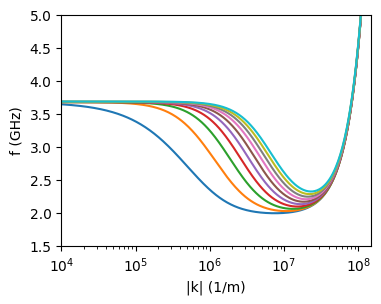

In [3]:
# Sort and plot the real frequencies as function of k vector aplitude

# Sort the frequencies
frsY = np.zeros((len(ks), eig_vals.shape[1]))
for i, h in enumerate(ks):
    fr = np.real(eig_vals[i]/(2j*np.pi))
    fr = fr[fr.argsort()]
    frsY[i] = fr

plt.close('spinwaves_k')
fig = plt.figure('spinwaves_k', (4,3))

#Plot the positive frequencies for the first 10 modes
for i in range(eig_vals.shape[1])[nZ:nZ+10]:
    plt.semilogx(ks, frsY[:, i]/1E9)

plt.xlim(1E4, 1.5E8)
plt.ylim(1.5, 5)
plt.xlabel('|k| (1/m)')
plt.ylabel('f (GHz)');